---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<br>
<br>

# Overview

## Dimension Reduction

### PCA

In this section, I will use text frequency-inverse document TF-IDF as my embedding method to vectorize our reviews data. My rationale for using only TF-IDF, comes from the questionable results obtained when I used only the bag-of-words approach in the [EDA](../eda/main.ipynb) section. Specifically, when looking only at single term frequency per review class, there were multiple instances where meaningless words appeared most frequently across all review scores. I was able to address this issue by instead bagging pairs of words (bigrams) instead, which yielded more intuitive results. Regardless, I choose only to use TF-IDF in this section because it considers both how often a term appears in a single review (Term Frequency), and how rare the term is accross all reviews (Inverse Document Frequency). This two-pronged approach punishes words that are common across the entire review corpus, while favoring those that are less common and therefore may have greater meaning. For further context on TF-IDF, see the equations outlined in the literature review on the [Home](../../index.qmd) page. 

After embedding the review text, I will leverage several different unsupervised learning techniques. To begin, I use two types of dimension reduction techniques to collapse the high-dimensional tf-idf matrix into a low dimensional space for easier visualization. For this, I will use Principle Components Analysis (PCA) and t-distributed Stochastic Neighbor Embedding. In case you are unfamiliar with these two topics - PCA works by identifying an axes in high-dimensional space, along which the preserved variance of the data is maximized. These so-called "principle" components are eigenvectors of the covariance matrix, and their selection (i.e. how many principle components we take) depends on the respective share of total variance preserved by their eigenvalues[@EigenPCA]. 

**Here is a helpful visualization of what is going on in PCA:**
<br>
![](../../xtra/multiclass-portfolio-website/images/pca.gif){width="600px"} 
<br>
Source: [Builtin](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

### t-SNE

On the other hand, t-SNE takes a non-linear, probabilistic approach to dimension reduction that works in two stages. First t-SNE constructs probability distributions over different pairs of high-dimensional points, where it then assigns higher probabilities to similar points and lower probabilities to dissimilar points[@WikiTSNE]. From there, t-SNE creates similar probability distributions in lower dimensional space, and shrinks the difference between the two distributions by minimizing the kullback-Leibler (KL) divergence between the two. In simple terms, the KL divergence simply measures the difference between two different probability distributions[@WikiKL]. T-SNE also requires the use of a `perplexity` hyperparameter, which represents a guess as to how many close neighbors a given point should have, or the "balance between preserving the global and local structure of the data"[@perplexity]. Feel free to head over [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for a more robust explanation of t-SNE and KL divergence.

**Example of how `perplexity` Influences t-SNE Results**
<br>
![](../../xtra/multiclass-portfolio-website/images/perplexity.png){width="600px"}
<br>
Source: [Single Cell Discoveries](https://www.scdiscoveries.com/blog/knowledge/what-is-t-sne-plot/)

## Clustering

Once the data is properly collapsed into a lower-dimensional space, I will apply several clustering methods in order to better understand how different pieces of text group together. For this, I will use K-Means Clustering, Hierarchical Clustering, and DBSCAN. The goal for using clustering methods within the context of this study is to uncover underlying patterns in text for different review rating scores. 

### K-Means

As a first step, I will apply a K-Means clustering algorithm to the dimension-reduced data. The K-Means alorithm starts by randomly selecting $k$ points in the dataset, where $k$ is a hyperparameter that we can optimize by using the elbow method (covered below). From there, the algorithm takes these $k$ centroids and calculates their distance to all other points in the data set, assigning all of the closest points to their respective centroid. For my distance metric, I elect use euclidean distance[@eucdistance]: 

$$
\text{for a point} \ x = (x_1, x_2, ..., x_n) \ \text{and centroid} \ \mu = (\mu_1, \mu_2, \mu_n) \ \text{their distance} \ d(x,\mu) = \sqrt{\sum_{i=1}^{n}(x_{i}-\mu_{i})^2}
$$

After all data points have been assigned to their initial clusters, we calculate the mean of all data points for a given cluster[@Week8Slides]:

$$
\mu_{j}^{\text{new}} \leftarrow \frac{1}{|S_{j}|} \sum_{x_{i} \in{S_{j}}} x_{i}
$$

From there, we repeat our disance calculation and cluster re-assignment until convergence.

**Example of K-Means Convergence**
<br>
![](../../xtra/multiclass-portfolio-website/images/kmeans.gif){width="400px"}
<br>
Source: [Wikipedia](https://commons.wikimedia.org/wiki/File:K-means_convergence.gif)

### Hierarchical Clustering

In the next step of the process, I will use hierarchical clustering to help extract text groupings from the data. Unlike K-Means clustering's reliance on centroids, hierarchical clustering uses a tree-based model of distance called a 'dendrogram' to analyze similarity of data points. The dendrogram is constructed through an interative process, where it progressively combines or splits up clusters based on the similarity of points within them. The process ends either when all points in the data are combined into a single cluster, or when a predefined number of clusters are formed. 

There are two different types of hierarchical clustering, agglomerative and divisive. Here, I elect to use agglomerative or "bottom-up" hierarchical clustering to group my data points. Take for example the case when our data set a the set letters \[A,B,C,D,E,F]. An agglomerative clustering model starts by treating each letter as its own cluster. In the next step, the model combines the most similar clusters. For instance, the model may merge together clusters B and C, and D and E, resulting in the new clusters \[A, BC, DE, F]. From there, the model calculates cluster distances again, merging clusters DE and F, leaving us with \[A, BC, DEF]. Eventually, the model will merge all clusters such that we have a single cluster \[ABCDEF] (Thanks to [geeksforgeeks](https://www.geeksforgeeks.org/hierarchical-clustering/) for this example).

**Simple Example of Agglomerative Clustering:**
<br>
![](../../xtra/multiclass-portfolio-website/images/agglomerative.png){width="400px"}
<br>
Source: [GeeksforGeeks](https://www.geeksforgeeks.org/hierarchical-clustering/)


### DBCSCAN

Density-based spatial clustering of applications with noice, or DBSCAN is a density-based approach to clustering data points. I elect to use this method of clustering in my analysis because the two methods above (K-Means and Agglomerative) are geared towards finding spherical- or convex-shaped clusters (shapes that are more well-defined and less noisy). In the case of low-dimensional representations of text data, it is highly likely that clusters will not be well-defined, and therefore may require an alternative method for extracting them. That is precisely where DBSCAN comes into play. The DBSCAN algorithm requires `eps` and `MinPts` parameters, where eps "defines the neighborhood around data points," wherein the distance between two points that are close to eachother (neighbors) approximately equal to `eps`[@eps]. The parameter `MinPts` simply defines the minimum number of data points within the eps radius, where larger data sets typically require a higher value of `MinPts`[@eps].

**Example of DBSCAN Clustering**
<br>
![](../../xtra/multiclass-portfolio-website/images/DBSCAN.gif){width="400px"}


# Code 

## Loading in Data and Libraries

Here, I begin by loading in all of the necessary libraries for dimension reduction and clustering. I am using the [`sklearn`](https://scikit-learn.org/stable/) package for KMeans and DBSCAN models, [`scipy`](https://scipy.org/) for agglomerative clustering, the `plotly` [python library](https://plotly.com/python/) for displaying interactive visualizations, and `pandas` for data manipulation. Below, I begin by unzipping the data file we worked with in the [EDA](../eda/main.ipynb) section.

In [1]:
# Data loading and manipulation packages
import pandas as pd
import numpy as np
import gzip

# Itertools product function to test all possible combinations of TF-IDF params for testing
from itertools import product


# Dimension reduction packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Clustering packages
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram

# Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Pathway to raw data
data_path = "../../data/processed-data/reviews_short.csv.gz"

# Unzip the CSV file
with gzip.open(data_path, 'rb') as f:
    # Read the CSV file into a dataframe
    reviews = pd.read_csv(f)

reviews.head(1)

,reviewRating,vote,verified,reviewTime,reviewerID,productID,reviewerName,reviewText,summary,reviewTextClean,summaryClean,binary_target
0,5.0,2,False,2016-06-17,A7HY1CEDK0204,B00I9GYG8O,Jor El,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.,youre looking cinema k capabilities budget cam...,filmmakers love camera,positive


## Text Embedding & Dimension Reduction

In this section, I vectorize our cleaned text data using the `TfidfVectorizer` object found in the [`sklearn`](https://scikit-learn.org/stable/) library. Like I said previously, I experienced some issues relating to poor performance when applying `CountVectorizer` to single terms. Therefore, in this section, I elect to run the TfidfVectorizer` on single words and bigrams, as its consideration of word weights allows it to punish terms that are commonly found across all classes (review scores in this case).  

**The plan going forward:**

- Conduct some preliminary baseline tests using PCA and t-SNE, and see which performs better when given our reviews data
- Take the higher performer of the two, and build out a refined function that can be used to iteratively test different parameters
- Once I find a result that I like, save it to a new variable for modeling down the line
- Test out BERT's `SentenceTransformer` tool for full sentence embedding, and see if this produces any interesting results
- Perform clustering on the two best sets of reduced data.


In [3]:
#| echo: false
reviews['reviewTextClean'] = reviews['reviewTextClean'].astype(str)

### Preliminary Tests: t-SNE vs PCA

To start off, lets create two simple plots of the data, using each of our two different dimension reduction techniques and TF-IDF embedding. To speed up the process, I will add a `N_SAMPLES` constant to allow for faster execution

**Sample TF-IDF Matrix**

In [12]:
N_SAMPLES = 10000
sampled_reviews = reviews.sample(n=N_SAMPLES, random_state=5000)

## Using tf-idf embedding
tfidf = TfidfVectorizer(max_features = 500, ngram_range=(1,2)) # Default params for our case: maximum features = 500 and consider both unigrams and bigrams 
X_tfidf = tfidf.fit_transform(sampled_reviews['reviewTextClean'])

**Standard PCA and t-SNE Reduction**

In [13]:
# Initializing PCA object 
pca = PCA(n_components=2, random_state=5000) #Default params for our case: 2 principle components
# Fitting to our embedded text
pca_data = pca.fit_transform(X_tfidf.toarray())

# Initializing t-SNE object
tsne = TSNE(n_components=2, perplexity=30, random_state=5000) # Default params for our case: 2 components, perplexity = 30, n_iter = 1000
# Fitting to our embedded text
tsne_data = tsne.fit_transform(X_tfidf.toarray())

**Plotting Results**

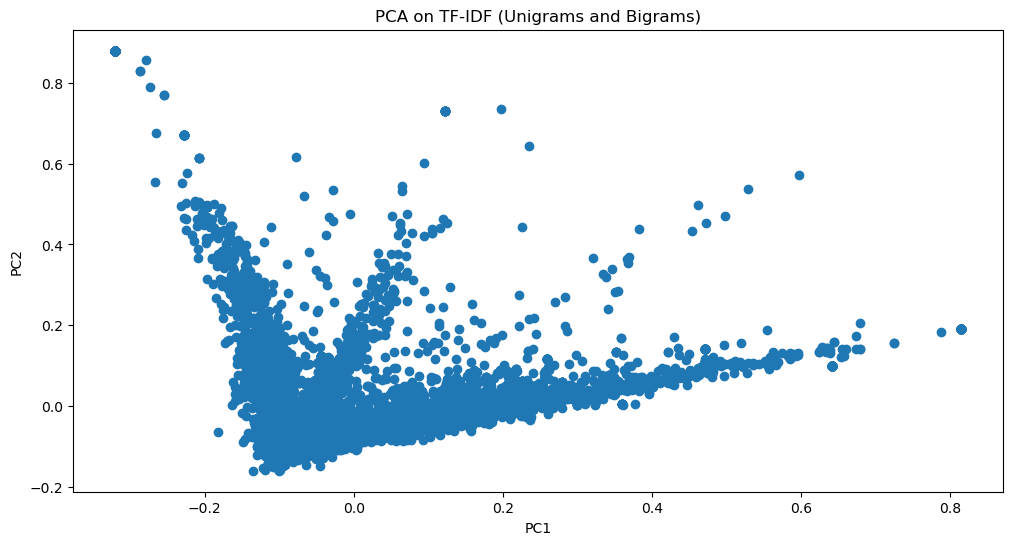

In [16]:
# Plotting PCA results
plt.figure(figsize=(12, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title("PCA on TF-IDF (Unigrams and Bigrams)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

The above PCA plot demonstrates a very strong linear structure, where most of the data poinrs are concentrated along a single dominant direction. The most likely reason for this is that our princple components analysis was heavily influenced by a small group of dominant features. When thinking about this within the context of our reviews data, it makes sense that there are especially strong features, as reviews are often repetitive and contain a lot of the same content, especially adjectives and in this case names of standard electronics (i.e. batteries, keyboards, storage, etc.)

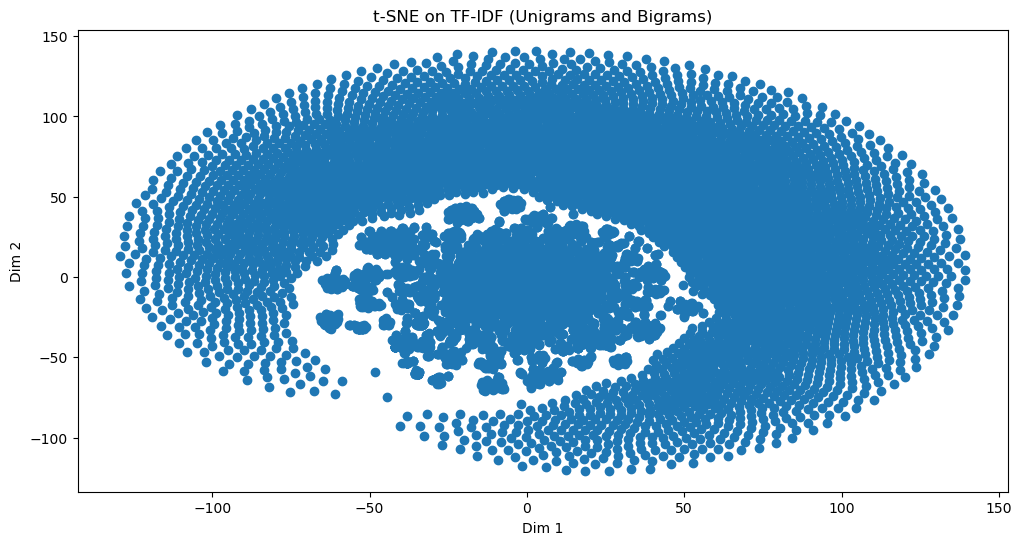

In [17]:
# Plotting t-SNE results
plt.figure(figsize=(12, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.title("t-SNE on TF-IDF (Unigrams and Bigrams)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In contrast to our PCA plot, the t-SNE plot above shows a bit more promise. Ignoring the massive circle of points on the outer ring of the plot, we can see that t-SNE is able to better capture localized groups in the data, which makes it more ideal for clustering. Of course, we will have to tune some parameters to get a better result, but this is a strong first step. Going into this first stage, I had a feeling that t-SNE would outperform PCA when collapsing our TF-IDF embeddings. 

Moving forward, I will shift my focus toward refining our t-SNE reduction process. Below, I outline a function that I will use to help speed up the process.

### Parameter Optimization

In [4]:
def plot_embeddings(data, title, labels=None, hover_data=None, top_terms=None):
    """
    Creates an interactive scatter plot using Plotly with hover data.
    
    Args:
        data (np.array): 2D array of reduced data (e.g., PCA or t-SNE output).
        title (str): Title of the plot.
        labels (pd.Series or None): Numeric labels for coloring the plot (e.g., reviewRating).
        hover_data (pd.DataFrame or None): DataFrame with hover information (optional).
        top_terms (list of str): List of most important terms for each review.
    """
    # Create a DataFrame for the plot
    plot_df = pd.DataFrame(data, columns=['Dim 1', 'Dim 2'])
    if labels is not None:
        plot_df['Rating'] = labels
    if hover_data is not None:
        plot_df = pd.concat([plot_df, hover_data.reset_index(drop=True)], axis=1)
    if top_terms is not None:
        plot_df['Top Term'] = top_terms

    # Generate the scatter plot
    fig = px.scatter(
        plot_df, 
        x='Dim 1', y='Dim 2', 
        color='Rating',  # Points are colored by the review rating
        hover_data=['Top Term'],  # Only show the most important term on hover
        color_continuous_scale='viridis',  # Use a color gradient for review ratings
        title=title
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(title=dict(x=0.5), legend=dict(orientation="h", y=-0.2))
    fig.show()


In [10]:
def reduce_and_visualize(reviews, method="tsne", sample_size=1000, random_state=42, perplexity=30, intermediate_pca=True):
    """
    Reduces dimensionality using PCA or t-SNE and visualizes the results with points colored by review rating.
    
    Args:
        reviews (pd.DataFrame): Original dataset containing 'reviewText' and 'reviewRating'.
        method (str): The dimensionality reduction method ('pca' or 'tsne').
        sample_size (int): Number of rows to sample for testing.
        random_state (int): Random state for reproducibility.
        perplexity (int): Perplexity value for t-SNE.
        intermediate_pca (bool): Whether to apply PCA before t-SNE.
    """
    # Sample the dataset for testing
    if sample_size < len(reviews):
        sampled_reviews = reviews.sample(n=sample_size, random_state=random_state).reset_index(drop=True)
    else:
        sampled_reviews = reviews.reset_index(drop=True)

    # Extract the relevant columns after sampling
    review_texts = sampled_reviews['reviewTextClean']
    review_ratings = sampled_reviews['reviewRating']  # Correctly aligned with reviewTextClean
    review_text = sampled_reviews['reviewText']

    # Simplified parameter grid
    param_grid = {
        'max_features': [500],                # Single value for faster processing
        'ngram_range': [(1, 2)],              # Focus on bigrams
        'min_df': [1],                        # Single min_df value
        'max_df': [0.8]                       # Single max_df value
    }
    
    for max_features, ngram_range, min_df, max_df in product(
        param_grid['max_features'], 
        param_grid['ngram_range'], 
        param_grid['min_df'], 
        param_grid['max_df']
    ):
        print(f"Testing Parameters: max_features={max_features}, ngram_range={ngram_range}, min_df={min_df}, max_df={max_df}")
        
        # Initialize TF-IDF
        tfidf = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=min_df,
            max_df=max_df
        )
        
        try:
            # Fit and transform the data
            X_tfidf = tfidf.fit_transform(review_texts)
            
            # Extract the most important term for each review
            feature_names = np.array(tfidf.get_feature_names_out())
            top_terms = feature_names[np.argmax(X_tfidf.toarray(), axis=1)]
            
            # Intermediate PCA step for t-SNE
            if intermediate_pca and method.lower() == "tsne":
                print("Applying intermediate PCA...")
                pca = PCA(n_components=50, random_state=random_state)
                X_reduced = pca.fit_transform(X_tfidf.toarray())
            else:
                X_reduced = X_tfidf.toarray()
            
            # Dimensionality reduction
            if method.lower() == "pca":
                reducer = PCA(n_components=2, random_state=random_state)
                reduced_data = reducer.fit_transform(X_reduced)
                title = f"PCA: max_features={max_features}, ngram_range={ngram_range}"
            
            elif method.lower() == "tsne":
                reducer = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, n_iter=500)
                reduced_data = reducer.fit_transform(X_reduced)
                title = f"t-SNE: max_features={max_features}, ngram_range={ngram_range}, perplexity={perplexity}"
            
            else:
                raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")
            
            # Prepare hover data
            hover_data = pd.DataFrame({
                'reviewText': review_text,  # Original review text
            })

            # Plot the reduced data with points colored by review rating
            plot_embeddings(
                reduced_data, 
                title, 
                labels=review_ratings,  # Points are colored by review ratings
                hover_data=hover_data,
                top_terms=top_terms
            )
        
        except Exception as e:
            print(f"Failed for parameters: {e}")


reduce_and_visualize(
    reviews=reviews,            # Pass the full dataset
    method="tsne",              # Choose "tsne" for t-SNE or "pca" for PCA
    sample_size=2000,           # Test on a sample of 2000 reviews
    random_state=42,            # Set a random state for reproducibility
    perplexity=50,              # Set the perplexity for t-SNE
    intermediate_pca=True       # Apply PCA before t-SNE
)

Testing Parameters: max_features=500, ngram_range=(1, 2), min_df=1, max_df=0.8
Applying intermediate PCA...


In [9]:
reduce_and_visualize(
    reviews=reviews,            # Pass the full dataset
    method="pca",              # Choose "tsne" for t-SNE or "pca" for PCA
    sample_size=10000,           # Test on a sample of 2000 reviews
    random_state=42,            # Set a random state for reproducibility
    perplexity=30,              # Set the perplexity for t-SNE
    intermediate_pca=True       # Apply PCA before t-SNE
)

Testing Parameters: max_features=500, ngram_range=(1, 2), min_df=1, max_df=0.8
